### Produce heatmap showing the concordance between original authors' annotations and the final annotation

In [1]:
import scanpy as sc 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
plots_dir = "../../../paper_figures/"

In [4]:
%%time
adata = sc.read_h5ad("../07_final_RNA_without_scvi.h5ad")
adata

CPU times: user 15.3 s, sys: 1min 21s, total: 1min 36s
Wall time: 3min 34s


AnnData object with n_obs × n_vars = 2305964 × 16115
    obs: 'age', 'donor_id', 'sex', 'region', 'cell_type', 'disease', 'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei', 'barcode', 'sample_id', 'age_status', 'tech_plus_study', 'disease_binary', 'decade', 'age_group', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'scvi_cell_type', 'redo_leiden_0.5', 'UMAP1', 'UMAP2', 'v2_scvi_cell_type', 'final_cell_type'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts'

In [5]:
Counter(adata.obs.final_cell_type)

Counter({'Cardiomyocyte': 676654,
         'Fibroblast': 548613,
         'Endothelial': 317124,
         'Pericyte': 281784,
         'Myeloid': 241337,
         'Lymphoid': 69128,
         'vSMC': 59357,
         'Endocardial': 42582,
         'Neuronal': 22613,
         'LEC': 13723,
         'Adipocyte': 12098,
         'Epicardial': 11993,
         'Mast': 8958})

In [6]:
def create_contigency_matrix(adata, adata_obs_column_1, adata_obs_column_2):
    '''
    Create a contingency matrix between two metadata fields in an adata object. 
    A row-normalized matrix is returned, such that the rows sum to 100%.
    Also produces a scatterplot.
    '''

    # extract the metadata
    adata_metadata = adata.obs

    # create the contigency matrix 
    contingency_matrix = pd.crosstab(adata_metadata[adata_obs_column_1], adata_metadata[adata_obs_column_2])

    # normalize so that rows sum to 100%
    norm_contigency_matrix = 100 * contingency_matrix.div(contingency_matrix.sum(axis = 1), axis = 0)

    # plot the heatmap
    plt.figure(figsize=(10, 8))  
    sns.heatmap(norm_contigency_matrix, 
                cmap='viridis', 
                annot=True, fmt='.1f',
                cbar=True)
    
    plt.title(f"Heatmap of consistency between {adata_obs_column_1} and {adata_obs_column_2}")
    plt.ylabel(f"{adata_obs_column_1}")
    plt.xlabel(f"{adata_obs_column_2}")
    plt.xticks(rotation=45)  
    plt.yticks(rotation=0)   
    plt.tight_layout()       

    return [plt, norm_contigency_matrix]

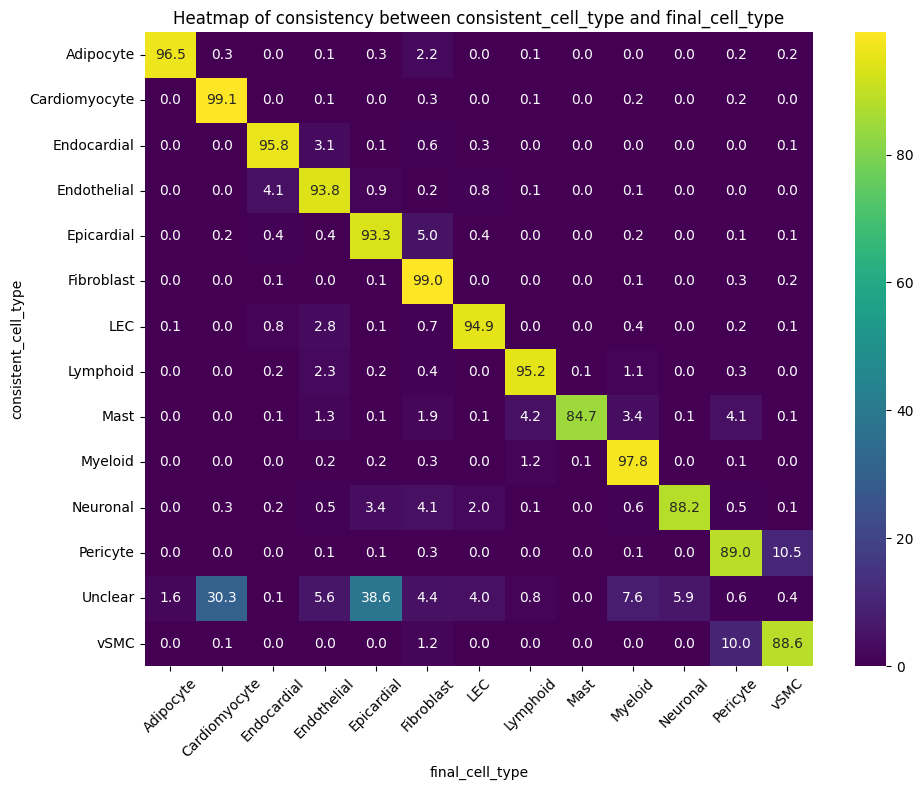

In [7]:
heatmap_plot, contingency_matrix = create_contigency_matrix(adata = adata, 
                         adata_obs_column_1="consistent_cell_type", # this is the key for the original annotation
                         adata_obs_column_2="final_cell_type") # this is the key for the final annotation

heatmap_plot.savefig(plots_dir + "snRNA_misclassification_heatmap.pdf")

### Accuracy appears to be worse for the rarer cell types

Look at the value of the non-diagonal

In [9]:
filt_contingency_matrix.shape

(13, 13)

In [10]:
error_rates = np.zeros(num_final_cell_types)

for i in np.arange(num_final_cell_types):
    # the error rate is 100 - the value in the diagonal
    non_diagonal_value = 100 - filt_contingency_matrix[i, i]
    error_rates[i] = non_diagonal_value

In [11]:
error_rates_df = pd.DataFrame({'cell_type': final_cell_types, 
                              'error_rates': error_rates})

error_rates_df

,cell_type,error_rates
0,Adipocyte,3.515498
1,Cardiomyocyte,0.894604
2,Endocardial,4.235052
3,Endothelial,6.172721
4,Epicardial,6.701512
5,Fibroblast,0.974152
6,LEC,5.087752
7,Lymphoid,4.792817
8,Mast,15.256886
9,Myeloid,2.166022


In [12]:
# also extract the total number of nuclei per cell type
nucs_per_cell_type = (adata.obs.groupby("final_cell_type").
                      count()[['donor_id']].reset_index().
                      rename(columns = {'donor_id': 'count',
                                       'final_cell_type': 'cell_type'})
                     )

# calculate proportion
nucs_per_cell_type['prop'] =  100 * nucs_per_cell_type['count'] / nucs_per_cell_type['count'].sum() 

/mnt/data1/william/tmp/ipykernel_3179186/1002540405.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nucs_per_cell_type = (adata.obs.groupby("final_cell_type").


In [13]:
merged_df = error_rates_df.merge(nucs_per_cell_type)
merged_df

,cell_type,error_rates,count,prop
0,Adipocyte,3.515498,12098,0.524640
1,Cardiomyocyte,0.894604,676654,29.343650
2,Endocardial,4.235052,42582,1.846603
3,Endothelial,6.172721,317124,13.752340
4,Epicardial,6.701512,11993,0.520086
5,Fibroblast,0.974152,548613,23.791048
6,LEC,5.087752,13723,0.595109
7,Lymphoid,4.792817,69128,2.997792
8,Mast,15.256886,8958,0.388471
9,Myeloid,2.166022,241337,10.465775


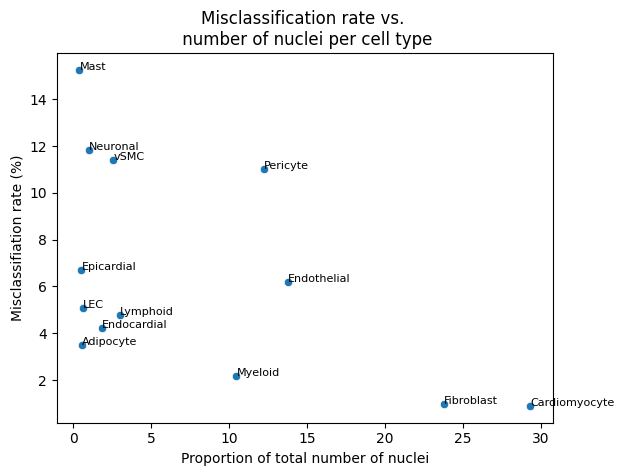

In [14]:
sns.scatterplot(data = merged_df, x = 'prop', y = 'error_rates')

for i, row in merged_df.iterrows():
    plt.text(row['prop'], row['error_rates'], row['cell_type'], 
             fontsize=8, ha='left') 

plt.xlabel("Proportion of total number of nuclei")
plt.ylabel("Misclassifiation rate (%)")
plt.title("Misclassification rate vs. \n number of nuclei per cell type")
plt.savefig(plots_dir + "snRNA_misclassification_v_abundance.pdf")
plt.show()